In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json

In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.1 MB/s eta 0:00:0000:0100:02
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=4b5656c70aa1474960119a997fd822176f8cc9a097ec51b26a843d9d1cf841ec
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SpotifyMillionPlaylistDataset") \
    .getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True) #for good show

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/30 09:21:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
import os
import glob
# List of file paths for the 5 JSON files you want to read
path_to_json = '/kaggle/input/spotify-million/data'
file_paths = glob.glob(os.path.join(path_to_json, "*.json"))[:250]
# Load the files into a DataFrame
spotify_df = spark.read.json(file_paths, multiLine=True)

# Show the schema or some data to verify
spotify_df.printSchema()
spotify_df.show(5)

root
 |-- info: struct (nullable = true)
 |    |-- generated_on: string (nullable = true)
 |    |-- slice: string (nullable = true)
 |    |-- version: string (nullable = true)
 |-- playlists: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- collaborative: string (nullable = true)
 |    |    |-- description: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- modified_at: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- num_albums: long (nullable = true)
 |    |    |-- num_artists: long (nullable = true)
 |    |    |-- num_edits: long (nullable = true)
 |    |    |-- num_followers: long (nullable = true)
 |    |    |-- num_tracks: long (nullable = true)
 |    |    |-- pid: long (nullable = true)
 |    |    |-- tracks: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- album_name: string (nullable = true)
 |    |    |    |

+--------------------+--------------------+
|                info|           playlists|
+--------------------+--------------------+
|{2017-12-03 08:41...|[{false, NULL, 10...|
|{2017-12-04 03:05...|[{false, NULL, 39...|
|{2017-12-03 08:41...|[{false, NULL, 34...|
|{2017-12-03 08:41...|[{false, When you...|
|{2017-12-03 08:41...|[{false, NULL, 20...|
+--------------------+--------------------+
only showing top 5 rows



In [7]:
from pyspark.sql.functions import explode,col, monotonically_increasing_id
# Explode the 'playlists' array so each row represents a playlist
exploded_playlists_df = spotify_df.select(explode(col("playlists")).alias("playlist"))

# Explode the 'tracks' array within each playlist so each row represents a track
playlist = exploded_playlists_df.select(
    col("playlist.pid").alias("playlist_id"),
    col("playlist.name").alias("playlist_name"),
    col("playlist.num_tracks"),
    col("playlist.num_albums"),
    col("playlist.num_artists"),
    col("playlist.num_followers"),
    col("playlist.num_edits"),
    col("playlist.duration_ms").alias("playlist_duration_ms"),
    col("playlist.collaborative"),
    col("playlist.modified_at"),
    col("playlist.tracks").alias("tracks")
)


# Show the resulting DataFrame
playlist.printSchema()

root
 |-- playlist_id: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- num_tracks: long (nullable = true)
 |-- num_albums: long (nullable = true)
 |-- num_artists: long (nullable = true)
 |-- num_followers: long (nullable = true)
 |-- num_edits: long (nullable = true)
 |-- playlist_duration_ms: long (nullable = true)
 |-- collaborative: string (nullable = true)
 |-- modified_at: long (nullable = true)
 |-- tracks: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- album_name: string (nullable = true)
 |    |    |-- album_uri: string (nullable = true)
 |    |    |-- artist_name: string (nullable = true)
 |    |    |-- artist_uri: string (nullable = true)
 |    |    |-- duration_ms: long (nullable = true)
 |    |    |-- pos: long (nullable = true)
 |    |    |-- track_name: string (nullable = true)
 |    |    |-- track_uri: string (nullable = true)



In [8]:
playlist.count()

250000

In [9]:
playlist.columns

['playlist_id',
 'playlist_name',
 'num_tracks',
 'num_albums',
 'num_artists',
 'num_followers',
 'num_edits',
 'playlist_duration_ms',
 'collaborative',
 'modified_at',
 'tracks']

In [10]:
track= playlist.select(col('playlist_id'),col('playlist_name'),
                              explode(col("tracks")).alias("track"))
tracks= track.select('playlist_id','playlist_name','track.*')
tracks

playlist_id,playlist_name,album_name,album_uri,artist_name,artist_uri,duration_ms,pos,track_name,track_uri
300000,April 2017,Cold Heart Killer,spotify:album:5jk...,Lia Marie Johnson,spotify:artist:4G...,212071,0,Cold Heart Killer,spotify:track:1IP...
300000,April 2017,digital druglord,spotify:album:30Q...,blackbear,spotify:artist:2c...,212027,1,do re mi,spotify:track:3Q3...
300000,April 2017,The Answers,spotify:album:0xU...,SoMo,spotify:artist:5A...,188093,2,Curve,spotify:track:0ry...
300000,April 2017,Mansionz,spotify:album:5WS...,mansionz,spotify:artist:2o...,230878,3,STFU,spotify:track:2p4...
300000,April 2017,No Promises (feat...,spotify:album:630...,Cheat Codes,spotify:artist:7D...,223503,4,No Promises (feat...,spotify:track:1lo...
300000,April 2017,Cherry On Top (fe...,spotify:album:2mh...,Felix Snow,spotify:artist:1q...,157200,5,Cherry On Top (fe...,spotify:track:0Cm...
300000,April 2017,Sounds From The O...,spotify:album:2yU...,WizKid,spotify:artist:3t...,211293,6,Come Closer,spotify:track:2zY...
300000,April 2017,Life Changes,spotify:album:4w5...,Thomas Rhett,spotify:artist:6x...,223626,7,Craving You,spotify:track:2d4...
300000,April 2017,Heartbreak on a F...,spotify:album:3za...,Chris Brown,spotify:artist:7b...,220963,8,Privacy,spotify:track:5ky...
300000,April 2017,Step Brothers,spotify:album:3fP...,G-Eazy,spotify:artist:02...,203613,9,Down For Me,spotify:track:3sz...


In [11]:
tracks.printSchema()

root
 |-- playlist_id: long (nullable = true)
 |-- playlist_name: string (nullable = true)
 |-- album_name: string (nullable = true)
 |-- album_uri: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_uri: string (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- pos: long (nullable = true)
 |-- track_name: string (nullable = true)
 |-- track_uri: string (nullable = true)



In [12]:
print(tracks.count()) #16596692
print(len(tracks.columns))

16596692
10


In [13]:
tracks.columns

['playlist_id',
 'playlist_name',
 'album_name',
 'album_uri',
 'artist_name',
 'artist_uri',
 'duration_ms',
 'pos',
 'track_name',
 'track_uri']

In [14]:
playlist.head()

Row(playlist_id=300000, playlist_name='April 2017', num_tracks=52, num_albums=51, num_artists=50, num_followers=1, num_edits=17, playlist_duration_ms=10791197, collaborative='false', modified_at=1493337600, tracks=[Row(album_name='Cold Heart Killer', album_uri='spotify:album:5jklzf0gB5fhxKQEfybk2x', artist_name='Lia Marie Johnson', artist_uri='spotify:artist:4GaA53bqvMoSs2WzEFGiLe', duration_ms=212071, pos=0, track_name='Cold Heart Killer', track_uri='spotify:track:1IPfImi6ZtZlZo90xPigfM'), Row(album_name='digital druglord', album_uri='spotify:album:30QoUTsSdpQuZunPNFsLnm', artist_name='blackbear', artist_uri='spotify:artist:2cFrymmkijnjDg9SS92EPM', duration_ms=212027, pos=1, track_name='do re mi', track_uri='spotify:track:3Q3myFA7q4Op95DOpHplaY'), Row(album_name='The Answers', album_uri='spotify:album:0xU39IVVOseJrIHwSGJvBI', artist_name='SoMo', artist_uri='spotify:artist:5AtWO8IEnjhRLzaVVQxFUs', duration_ms=188093, pos=2, track_name='Curve', track_uri='spotify:track:0ryTG37E4pefNDkd6

In [15]:
from pyspark.sql.functions import col, count, when

In [16]:
# Count missing values for each column in playlist
missing_values_p = playlist.select([count(when(col(c).isNull(), c)).alias(c) for c in playlist.columns])
missing_values_p

playlist_id,playlist_name,num_tracks,num_albums,num_artists,num_followers,num_edits,playlist_duration_ms,collaborative,modified_at,tracks
0,0,0,0,0,0,0,0,0,0,0


In [17]:
# Count missing values for each column in tracks
missing_values_t = tracks.select([count(when(col(c).isNull(), c)).alias(c) for c in tracks.columns])
missing_values_t

playlist_id,playlist_name,album_name,album_uri,artist_name,artist_uri,duration_ms,pos,track_name,track_uri
0,0,0,0,0,0,0,0,0,0


In [18]:
# Remove duplicate rows

playlist_cleaned = playlist.dropDuplicates()
print(playlist.count())
print(playlist_cleaned.count())

250000


250000


In [19]:
# Remove duplicate rows

tracks_cleaned = tracks.dropDuplicates()
print(tracks.count())
print(tracks_cleaned.count())

16596692


24/08/30 09:34:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:34:25 WARN RowBasedKeyValueBatch: Calling spill() on

16596692


In [20]:
from pyspark.sql.functions import col, unix_timestamp, from_unixtime, countDistinct, avg,sum, when,dayofweek

In [21]:
# Converting Unix timestamp to readable date
playlist = playlist.withColumn("modified_at_date", from_unixtime(col("modified_at")))
playlist.select(['modified_at','modified_at_date'])

modified_at,modified_at_date
1493337600,2017-04-28 00:00:00
1475366400,2016-10-02 00:00:00
1380672000,2013-10-02 00:00:00
1506124800,2017-09-23 00:00:00
1508198400,2017-10-17 00:00:00
1492819200,2017-04-22 00:00:00
1490572800,2017-03-27 00:00:00
1469232000,2016-07-23 00:00:00
1469232000,2016-07-23 00:00:00
1409011200,2014-08-26 00:00:00


In [22]:
# Encoding categorical features 
playlist = playlist.withColumn("collaborative", when(col("collaborative") == "true", 1).otherwise(0))
playlist.select('collaborative')

collaborative
0
0
0
1
0
0
0
0
0
0


In [23]:
from pyspark.sql.types import LongType

# Ensure duration_ms is numeric
tracks = tracks.withColumn("duration_ms", col("duration_ms").cast(LongType()))

In [24]:
# Convert duration_ms to minutes as decimal
playlist = playlist.withColumn(
    "playlist_duration_min",
    col("playlist_duration_ms") / 60000
)
playlist.select(['playlist_id','playlist_duration_ms','playlist_duration_min'])

playlist_id,playlist_duration_ms,playlist_duration_min
300000,10791197,179.85328333333334
300001,2321683,38.694716666666665
300002,6863041,114.38401666666667
300003,38121216,635.3536
300004,19945959,332.43265
300005,6405596,106.75993333333334
300006,46375629,772.92715
300007,13593001,226.55001666666666
300008,9503891,158.39818333333332
300009,8336281,138.93801666666667


In [25]:
# Convert duration_ms to minutes as decimal
tracks = tracks.withColumn(
    "track_duration_min",
    col("duration_ms") / 60000
)
tracks.select(['duration_ms','track_duration_min'])

duration_ms,track_duration_min
212071,3.5345166666666668
212027,3.5337833333333335
188093,3.1348833333333332
230878,3.8479666666666668
223503,3.72505
157200,2.62
211293,3.52155
223626,3.7271
220963,3.682716666666667
203613,3.39355


In [26]:
# Example of creating time-based features
playlist= playlist.withColumn("day_of_week", dayofweek(col("modified_at_date")))
playlist.select(['day_of_week','modified_at_date'])

day_of_week,modified_at_date
6,2017-04-28 00:00:00
1,2016-10-02 00:00:00
4,2013-10-02 00:00:00
7,2017-09-23 00:00:00
3,2017-10-17 00:00:00
7,2017-04-22 00:00:00
2,2017-03-27 00:00:00
7,2016-07-23 00:00:00
7,2016-07-23 00:00:00
3,2014-08-26 00:00:00


In [27]:
playlist.columns

['playlist_id',
 'playlist_name',
 'num_tracks',
 'num_albums',
 'num_artists',
 'num_followers',
 'num_edits',
 'playlist_duration_ms',
 'collaborative',
 'modified_at',
 'tracks',
 'modified_at_date',
 'playlist_duration_min',
 'day_of_week']

In [28]:
playlist = playlist.drop("playlist_duration_ms", "modified_at",'tracks')
playlist.columns

['playlist_id',
 'playlist_name',
 'num_tracks',
 'num_albums',
 'num_artists',
 'num_followers',
 'num_edits',
 'collaborative',
 'modified_at_date',
 'playlist_duration_min',
 'day_of_week']

In [29]:
tracks.columns

['playlist_id',
 'playlist_name',
 'album_name',
 'album_uri',
 'artist_name',
 'artist_uri',
 'duration_ms',
 'pos',
 'track_name',
 'track_uri',
 'track_duration_min']

In [30]:
tracks=tracks.drop('album_uri','artist_uri','track_uri','duration_ms')
tracks.columns

['playlist_id',
 'playlist_name',
 'album_name',
 'artist_name',
 'pos',
 'track_name',
 'track_duration_min']

In [31]:
# Save DataFrame as Parquet file
tracks.write.parquet("/kaggle/working/tracks.parquet")
playlist.write.parquet("/kaggle/working/playlist.parquet")

In [32]:
import shutil

# Compress the Parquet files into a ZIP archive
shutil.make_archive("/kaggle/working/spotify_tracks", 'zip', "/kaggle/working", "tracks.parquet")
shutil.make_archive("/kaggle/working/spotify_playlist", 'zip', "/kaggle/working", "playlist.parquet")


'/kaggle/working/spotify_playlist.zip'

In [33]:
# Count the number of modifications for each day of the week
day_of_week_counts = playlist.groupBy("day_of_week").count().orderBy("day_of_week")

# Show the results
day_of_week_counts.show()

+-----------+-----+
|day_of_week|count|
+-----------+-----+
|          1|32251|
|          2|37177|
|          3|39102|
|          4|35468|
|          5|35326|
|          6|37476|
|          7|33200|
+-----------+-----+



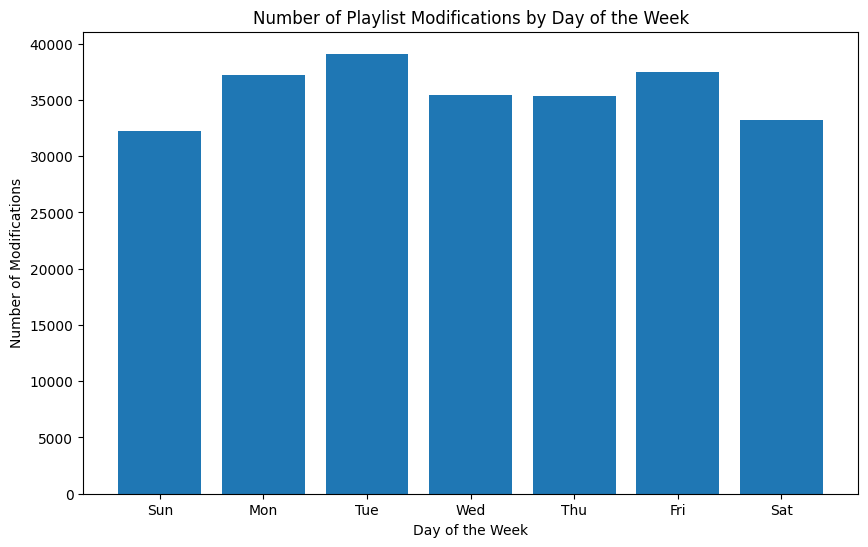

In [34]:
# Convert to Pandas DataFrame for easy plotting
day_of_week_counts_pd = day_of_week_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(day_of_week_counts_pd['day_of_week'], day_of_week_counts_pd['count'])
plt.xlabel('Day of the Week')
plt.ylabel('Number of Modifications')
plt.title('Number of Playlist Modifications by Day of the Week')
plt.xticks(ticks=range(1, 8), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()

In [35]:
# Filter for a specific day of the week (e.g., Friday)
Tue_playlists = playlist.filter(col("day_of_week") == 2)

# Investigate further, e.g., average track count, duration, etc.
friday_insights = Tue_playlists.groupBy("playlist_id").agg(
    avg("num_tracks").alias("avg_track_count"),
    avg("playlist_duration_min").alias("avg_duration_min")
)

# Show results
friday_insights.show()

+-----------+---------------+------------------+
|playlist_id|avg_track_count|  avg_duration_min|
+-----------+---------------+------------------+
|     300799|           59.0|         221.08025|
|     850368|           59.0|218.29456666666667|
|     240081|           61.0|          248.0575|
|     240684|           75.0| 332.1485333333333|
|     850329|           19.0|           73.0454|
|     300177|          232.0| 903.6578333333333|
|     240491|           71.0|         261.45355|
|     240909|           55.0|228.71923333333334|
|     300967|           96.0|423.35426666666666|
|     850675|           70.0| 266.0100166666667|
|     240303|           86.0|301.49033333333335|
|     240242|          171.0| 647.7412666666667|
|     300577|          146.0| 695.5689166666667|
|     300931|           24.0| 94.02526666666667|
|     850151|           12.0| 43.99373333333333|
|     850887|           67.0|          267.4819|
|     240429|           88.0|         302.78965|
|     300654|       

In [36]:
# Calculate the average number of modifications per playlist for each day of the week
avg_modifications_by_day = playlist.groupBy("day_of_week").agg(
    avg("playlist_id").alias("avg_modifications")
).orderBy("day_of_week")

# Show the results
avg_modifications_by_day.show()

+-----------+------------------+
|day_of_week| avg_modifications|
+-----------+------------------+
|          1| 477191.9012433723|
|          2| 479240.9410388143|
|          3|  479735.360416347|
|          4|478082.41482463066|
|          5|  477999.854186718|
|          6|479813.30710321275|
|          7|478393.76596385543|
+-----------+------------------+



In [37]:
# Aggregating track-level data
playlist_agg_df = tracks.groupBy("playlist_id").agg(
    countDistinct("artist_name").alias("unique_artists"),
    countDistinct("album_name").alias("unique_albums"),
    avg("track_duration_min").alias("avg_track_duration_min"),
    sum("track_duration_min").alias("total_duration_min")
)
playlist_agg_df

24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/08/30 09:44:35 WARN RowBasedKeyValueBatch: Calling spill() on

playlist_id,unique_artists,unique_albums,avg_track_duration_min,total_duration_min
2040,39,46,3.585172549019607,182.84379999999996
2214,37,40,3.8654936170212753,181.67819999999995
2250,44,55,3.8086601010101,251.3715666666666
2453,75,97,3.667706913580249,495.14043333333365
2509,38,44,3.517371481481481,158.28171666666665
2529,32,37,5.198981914893618,244.35215000000002
2927,20,20,3.848508695652175,88.51570000000002
6721,16,19,3.7874365384615385,98.47335
11190,10,10,3.9059066666666666,39.059066666666666
11276,21,32,3.8139468036529713,835.2543500000007


In [38]:
from pyspark.sql.functions import col, count, when

# 'track.artist_name' is the column with artist names
artist_counts = (
    tracks
    .select(['playlist_name','album_name','artist_name'])  # Select the artist name column
    .groupBy('artist_name')            # Group by artist name
    .agg(count('artist_name').alias('count'))  # Count occurrences
    .orderBy(col('count').desc())      # Sort by count in descending order
    .limit(10)                         # Limit to top 10
)



# Show the top 10 most common artists
artist_counts

artist_name,count
Drake,214326
Kanye West,105793
Kendrick Lamar,89556
Rihanna,85518
The Weeknd,79316
Eminem,74661
Ed Sheeran,67530
Future,63652
J. Cole,61810
Justin Bieber,60203


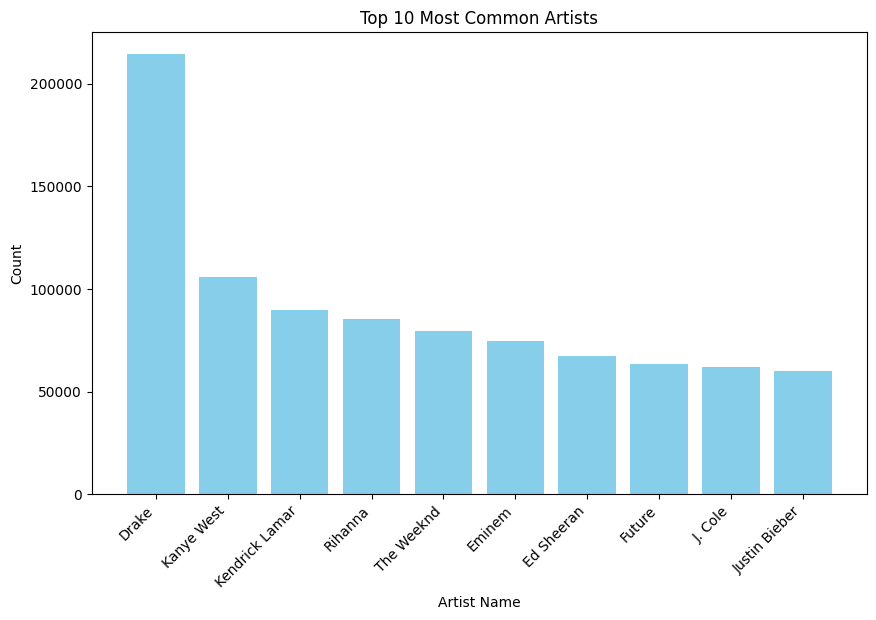

In [39]:
# Convert Spark DataFrame to Pandas DataFrame
artist_counts_pd = artist_counts.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(artist_counts_pd['artist_name'], artist_counts_pd['count'], color='skyblue')
plt.xlabel('Artist Name')
plt.ylabel('Count')
plt.title('Top 10 Most Common Artists')
plt.xticks(rotation=45, ha='right')
plt.show()